Image classification with CNNs
================

The goal of this exercise is to implement a specific CNN architecture with PyTorch and train it on the CIFAR-10 image classification dataset. We will start by introducing the dataset and then implement a `nn.Module` and a useful `Solver` class. Seperating the model from the actual training has proven itself as a sensible design decision. By the end of this exercise you should have succesfully trained your (possible) first CNN model and have a boilerplate `Solver` class which you can reuse for the next exercise and your future research projects.

For an inspiration on how to implement a model or the solver class you can have a look at [these](https://github.com/pytorch/examples) PyTorch examples.

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from dl4cv.classifiers.classification_cnn import ClassificationCNN
from dl4cv.data_utils import get_CIFAR10_datasets, OverfitSampler, rel_error

#torch.set_default_tensor_type('torch.FloatTensor')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


CIFAR-10 Dataset
=========

Since the focus of this exercise should be neural network models and how to successfully train them, we provide you with preprocessed and prepared datasets. For an even easier management of the train, validation and test data pipelines we provide you with custom `torch.utils.data.Dataset` classes. Use the official [documentation](http://pytorch.org/docs/data.html) to make yourself familiar with the `Dataset` and `DataLoader` classes. Think about how you have to integrate them in your training loop and have a look at the data preprocessing steps in `dl4cv/data_utils.py`.

The `num_workers` argument of the `DataLoader` class allows you to preprocess data with multiple threads.

<div class="alert alert-info">
    <h3>Note</h3>
    <p>In this case we generated the `Dataset` classes after we applied all the preprocessing steps. Other datasets or random data augmentation might require an online preprocessing which can be integrated into the `Dataset` classes. See `torchvision.Transform` for examples.</p>
</div>

In [165]:
# Load the (preprocessed) CIFAR10 data. The preprocessing includes
# channel swapping, normalization and train-val-test splitting.
# Loading the datasets might take a while.

train_data, val_data, test_data, mean_image = get_CIFAR10_datasets()
print("Train size: %i" % len(train_data))
print("Val size: %i" % len(val_data))
print("Test size: %i" % len(test_data))

Train size: 48000
Val size: 1000
Test size: 1000


Visualize Examples
------------------

To make yourself familiar with the dataset we visualize some examples. We show a few examples from each class. Note that we have to revert (transposition and mean subtraction) some preprocessing steps.

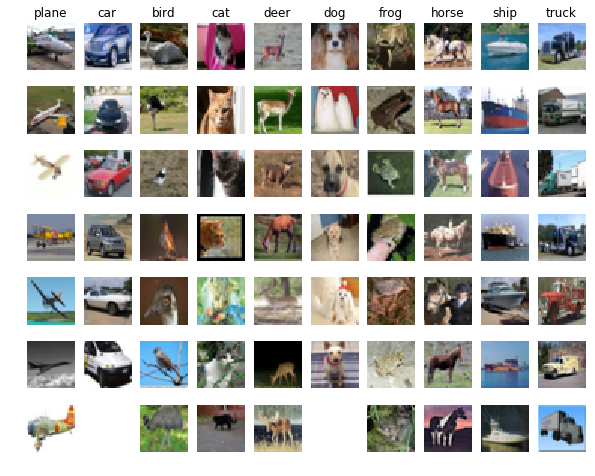

In [166]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for cls_idx, cls in enumerate(classes):
    cls_data = [datum for datum in test_data if datum[1] == cls_idx]
    rnd_idxs = np.random.randint(0, len(cls_data), samples_per_class)
    rnd_cls_data = [datum for i, datum in enumerate(cls_data) if i in rnd_idxs]
    for i, cls_datum in enumerate(rnd_cls_data):
        plt_idx = i * num_classes + cls_idx + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(cls_datum[0].numpy().transpose(1,2,0) + mean_image.transpose(1,2,0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# Model Architecture and Forward Pass 

After you understood the core concepts of PyTorch and have a rough idea on how to implement your own model, complete the initialization and forward methods of the `ClassificationCNN` in the `dl4cv/classifiers/classification_cnn.py` file. Note that we do not have to implement a backward pass since this is automatically handled by the `autograd` package.

Use the cell below to check your results:

In [167]:
# from dl4cv.classifiers.classification_cnn import ClassificationCNN

torch.manual_seed(0)
np.random.seed(0)

X = np.random.randn(2, 3, 5, 5).astype(np.float32)
X_tensor = torch.from_numpy(X.copy())
inputs = Variable(X_tensor)

model = ClassificationCNN(input_dim=(3, 5, 5), num_classes=3, kernel_size=3)
print(model)
outputs = model.forward(inputs)
correct_outputs = np.array([[-0.012747,    0.05964366,  0.03898076],
                            [-0.01286934,  0.05963349,  0.03903975]])

# The difference should be very small. We get < 1e-6
print('Difference between the correct and your forward pass:')
print(rel_error(correct_outputs, outputs.data.numpy()))

ClassificationCNN(
  (conv): Conv2d (3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (fc1): Linear(in_features=128, out_features=100)
  (dropout): Dropout(p=0.0)
  (fc2): Linear(in_features=100, out_features=3)
)
Difference between the correct and your forward pass:
0.816590618557


## Training and Validation with the Solver
We train and validate our previously generated model with a seperate `Solver` class defined in `dl4cv/solver.py`. Complete the `.train()` method and try to come up with an efficient iteration scheme as well as an informative training logger.

Use the cells below to test your solver. A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

<div class="alert alert-info">
    <h3>Note</h3>
    <p>As seen below, the design of our `Solver` class is indepdenent of the particular model or data pipeline. This facilitates the reuse of the class and its modular structure allows the training of different models.</p>
</div>

In [200]:
from dl4cv.classifiers.classification_cnn import ClassificationCNN
from dl4cv.solver import Solver

num_train = 100
train_loader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=False, num_workers=4,
                                           sampler=OverfitSampler(num_train))
val_loader = torch.utils.data.DataLoader(val_data, batch_size=50, shuffle=False, num_workers=4)

overfit_model = ClassificationCNN()
print(overfit_model)
overfit_solver = Solver(optim_args={"lr": 1e-2})
overfit_solver.train(overfit_model, train_loader, val_loader, log_nth=1, num_epochs=10)

ClassificationCNN(
  (conv): Conv2d (3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (max_pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (fc1): Linear(in_features=8192, out_features=100)
  (dropout): Dropout(p=0.0)
  (fc2): Linear(in_features=100, out_features=10)
)
START TRAIN.
[Iteration : 1/20] : 10.117610931396484
[Epoch : 0/10] : 10.117610931396484
[Iteration : 2/20] : 4.462010383605957
[Epoch : 0/10] : 4.462010383605957
[Iteration : 3/20] : 3.4118597507476807
[Epoch : 1/10] : 3.4118597507476807
[Iteration : 4/20] : 2.351179838180542
[Epoch : 1/10] : 2.351179838180542
[Iteration : 5/20] : 2.421070098876953
[Epoch : 2/10] : 2.421070098876953
[Iteration : 6/20] : 1.9544368982315063
[Epoch : 2/10] : 1.9544368982315063
[Iteration : 7/20] : 1.7992979288101196
[Epoch : 3/10] : 1.7992979288101196
[Iteration : 8/20] : 1.6776307821273804
[Epoch : 3/10] : 1.6776307821273804
[Iteration : 9/20] : 1.6393507719039917
[Epoch : 4/10] : 1.6393507719039917
[Itera

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

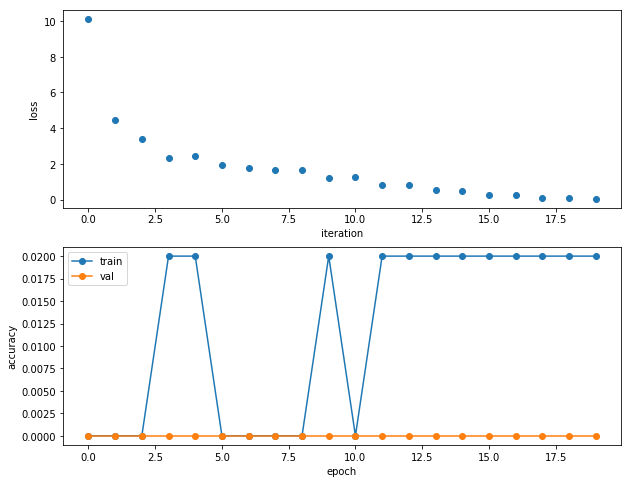

In [201]:
plt.subplot(2, 1, 1)
plt.plot(overfit_solver.train_loss_history, 'o')
plt.plot(overfit_solver.val_loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(overfit_solver.train_acc_history, '-o')
plt.plot(overfit_solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the Network
Now train your model with the full dataset. By training a `ThreeLayerCNN` model for one epoch, you should already achieve greater than 40% accuracy on the validation set. If your training is painfully slow check if you did not forget to call the `nn.Module.cuda()` method.

For the overfitting example we provided you with a set of hyperparamters (`hidden_dim`, `lr`, `weight_decay`, ...). You can start with the same parameter values but in order to maximize your accuracy you should try to train multiple models with different sets of hyperparamters. This process is called hyperparameter optimization.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from networks.classifiers.relay_net import ReLayNet
from networks.data_utils import get_imdb_data

#torch.set_default_tensor_type('torch.FloatTensor')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
train_data, test_data = get_imdb_data()
print("Train size: %i" % len(train_data))
print("Test size: %i" % len(test_data))

Train size: 88
Test size: 22


In [56]:
from networks.classifiers.relay_net import ReLayNet
from networks.solver import Solver

train_loader = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=2, shuffle=False, num_workers=4)

param ={
        'num_channels':1,
        'num_filters':64,
        'kernel_h':7,
        'kernel_w':3,
        'kernel_c': 1,
        'stride_conv':1,
        'pool':2,
        'stride_pool':2,
        'num_class':10
    }

relaynet_model = ReLayNet(param)
solver = Solver(optim_args={"lr": 1e-2})
solver.train(relaynet_model, train_loader, val_loader, log_nth=10, num_epochs=10)


START TRAIN.


/home/deeplearning/Abhijit/Git Projects/relaynet_pytorch/networks/classifiers/losses.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.nll_loss(F.log_softmax(inputs), targets)


[Iteration : 0/100] : 5.8561296463012695
[Iteration : 36/100] : 4.329807758331299
[Iteration : 72/100] : 3.681154251098633
[Iteration : 108/100] : 3.964773416519165
[Iteration : 144/100] : 3.490737199783325
[Iteration : 180/100] : 3.372708320617676
[Iteration : 216/100] : 3.4942984580993652
[Iteration : 252/100] : 3.9024245738983154
[Iteration : 288/100] : 3.8169803619384766
[Iteration : 324/100] : 3.980133295059204
[Iteration : 360/100] : 3.471912384033203
[Iteration : 396/100] : 3.562856674194336
[Iteration : 432/100] : 3.4636595249176025
[Iteration : 468/100] : 4.038578510284424
[Iteration : 504/100] : 3.7613589763641357
[Iteration : 540/100] : 4.025904655456543
[Iteration : 576/100] : 3.6280288696289062
[Iteration : 612/100] : 3.3704488277435303
[Iteration : 648/100] : 3.435544490814209
[Iteration : 684/100] : 3.571272373199463
[Iteration : 720/100] : 3.804269790649414
[Iteration : 756/100] : 3.7091193199157715
[Iteration : 792/100] : 3.866035223007202
[Iteration : 828/100] : 3.692

Process Process-46:
Process Process-48:
Process Process-45:
Process Process-47:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/deeplearning/anaconda3/envs/pytorch/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/deeplearning/anaconda3/envs/pytorch/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deeplearning/anaconda3/envs/pytorch/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/deeplearning/anaconda3/envs/pytorch/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deeplearning/anaconda3/envs/pytorch/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/deeplearning/anaconda3/envs/pytorch/lib/python3.5/multiproce

KeyboardInterrupt: 

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following. If your kernel visualizations do not exhibit clear structures try optimizing the weight scale:

In [ ]:
from dl4cv.vis_utils import visualize_grid

# first (next) parameter should be convolutional
conv_params = next(model.parameters()).data.numpy()
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(6, 6)
plt.show()

# Test your Model
Run your best model on the test set. You should easily achieve a score above 10% (random guessing for a classification task with 10 classes) accuracy on the given test set:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=50, shuffle=False, num_workers=4)

scores = []
for inputs, target in test_loader:
    inputs, targets = Variable(inputs), Variable(target)
    if model.is_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    scores.extend((preds == targets).data.cpu().numpy())
    
print('Test set accuracy: %f' % np.mean(scores))

## Save the Model

When you are satisfied with your training, you can save the model.

In [57]:
relaynet_model.save("models/relaynet_try1.model")

Saving model... models/relaynet_try1.model


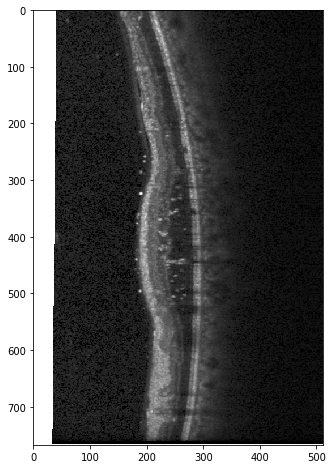

In [58]:
import h5py
import matplotlib.pyplot as plt
NumClass = 10

# Load DATA
Data = h5py.File('datasets/Data.h5', 'r')
a_group_key = list(Data.keys())[0]
Data = list(Data[a_group_key])
Data = np.squeeze(np.asarray(Data))
Label = h5py.File('datasets/label.h5', 'r')
a_group_key = list(Label.keys())[0]
Label = list(Label[a_group_key])
Label = np.squeeze(np.asarray(Label))
set = h5py.File('datasets/set.h5', 'r')
a_group_key = list(set.keys())[0]
set = list(set[a_group_key])
set = np.squeeze(np.asarray(set))
sz = Data.shape


Data = Data.reshape([sz[0], 1, sz[1], sz[2]])
idx = np.squeeze(Data[1,:,:,:])
plt.imshow(idx)
plt.show()
# weights = Label[:,1,:,:]
# Label = Label[:, 0, :, :]
# sz = Label.shape
# Label = Label.reshape([sz[0], 1, sz[2], sz[1]])
# weights = weights.reshape([sz[0], 1, sz[2], sz[1]])
# train_id = set == 1
# test_id = set == 3

# Tr_Dat = Data[train_id, :, :, :]
# Tr_Label = np.squeeze(Label[train_id,:,:,:])
# Tr_weights = weights[train_id,:,:,:]
# Tr_weights = np.tile(Tr_weights,[1, NumClass, 1, 1])

# Te_Dat = Data[test_id, :, :, :]
# Te_Label = np.squeeze(Label[test_id, :, :, :])
# Te_weights = weights[test_id, :, :, :]
# Te_weights = np.tile(Te_weights, [1, NumClass, 1, 1])

# sz = Tr_Dat.shape
# sz_test = Te_Dat.shape
# y2 = np.ones((sz[0], NumClass, sz[2], sz[3]))
# y_test = np.ones((sz_test[0], NumClass, sz_test[2], sz_test[3]))
# for i in range(NumClass):
#     y2[:, i, :, :] = np.squeeze(np.multiply(np.ones(Tr_Label.shape),((Tr_Label == i))))
#     y_test[:, i, :, :] = np.squeeze(np.multiply(np.ones(Te_Label.shape), ((Te_Label == i))))

# Tr_Label_bin = y2
# Te_Label_bin = y_test


torch.Size([1, 10, 768, 512])


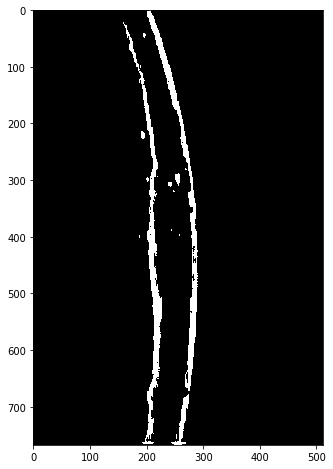

In [62]:
import matplotlib.pyplot as plt

out = relaynet_model(Variable(torch.Tensor(train_data.X[0:1]).cuda(),volatile=True))
print(out.data.shape)
max_val, idx = torch.max(out,1)
idx = idx.data.cpu().numpy()
idx = np.squeeze(idx==7)
plt.imshow(idx)
plt.show()

## Scoring function
We will score the model you have just saved based on the classification accuracy on our test dataset. The scoring function should represent the difficulty of obtaining a good test accuracy and should therefore give 0 points for worse results than random guessing, should be linear in a first regime and exponential beyond that. The onset of exponential growth depends on the problem. In that region you get twice as many points for an additional 10% accuracy.

For this problem we specifically use the following scoring function:

$$f(x) = \left\{
	\begin{array}{ll}
		0  & \mbox{if } x \leq 0.1 \\
		100x & \mbox{if } 0.1 < x \leq 0.58 \\
        \left(\frac{58}{\exp(0.58 \ln(2)/0.1)}\right) \exp(x \ln(2)/0.1) & \mbox{if } 0.58 < x \leq 1
	\end{array}
\right.$$

The function can be plotted in the following cell.

In [ ]:
relaynet_model()

In [ ]:
from dl4cv.data_utils import scoring_function

x = np.linspace(0, 1, num=1000)
plt.plot(x, scoring_function(x, lin_exp_boundary=0.58, doubling_rate=0.1))
plt.title('Scoring Function')
plt.xlabel('Test Accuracy')
plt.ylabel('Score')
plt.show()

## Possible Next Steps

1. Hyperparameter optimization
2. Data augmentation ([PyTorch tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html))
3. Improve your network architecture
    1. Increase network depth
    2. Make network convolutional
    2. Add additional layers such as [Batch normalization](https://gab41.lab41.org/batch-normalization-what-the-hey-d480039a9e3b#).
